In [79]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci_optim
from sklearn.decomposition import PCA
from functions import *


In [80]:
# Load data

data = pd.read_csv('Data/non_nan_data.csv')
data = data.drop(['sun_mean', 'wind_mean', 'temp_mean', 'DK1_spot'], axis=1)

cols_to_lag = [col for col in data.columns if col.startswith('sun_') or col.startswith('temp_') or col.startswith('wind_')]
data[cols_to_lag] = data[cols_to_lag].shift(1)

data = data.dropna()

# Split data
data_train = data[(data['DATE'] >= '2014-01-01') & (data['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy()
data_test = data[data['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy()

# To only use weather data one hour before the price, we lag weather data one hour
y_train = data_train[:, 0].reshape(-1, 1)
y_test = data_test[:, 0].reshape(-1, 1)

weather_train = data_train[:, 1:]
weather_test = data_test[:, 1:]

hour_dummies_train = sdummy(len(data_train), 24)
hour_dummies_test = sdummy(len(data_test), 24)

all_train = np.concatenate((weather_train, hour_dummies_train), axis=1)
all_test = np.concatenate((weather_test, hour_dummies_test), axis=1)

In [81]:
def perform_pca_and_residual_analysis(X, n_components):
    # Perform PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Reconstruct the original dataset from the PCA-transformed data
    X_reconstructed = pca.inverse_transform(X_pca)
    
    # Calculate the residuals (difference between original and reconstructed data)
    residuals = X - X_reconstructed
    residual_error = np.linalg.norm(residuals, axis=1)  # Calculate the error norm for each sample
    
    # Return the residual error and the first n principal components
    return X_pca, residual_error

In [82]:
X_pca, residual_error = perform_pca_and_residual_analysis(weather_train, 2)
X_pca.shape

/Users/emilbisiach/miniconda3/envs/dev_env/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:611: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


(78887, 2)

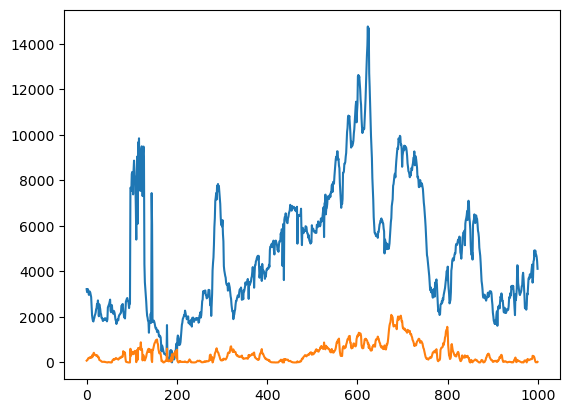

In [83]:
plt.plot(X_pca[0:1000]**2)

In [84]:
pca = PCA() # initialise PCA class
pca.fit(weather_train) # .fit() takes dimensions (n_samples, n_features). Therefore, X should have dimensions (N,d) = (F, |chi|)= (100,101) 
components = pca.components_ # return principal components matrix
singvals_i = pca.singular_values_ # return sigularvalues sorted in descending order

eigvals_i = singvals_i ** 2 # Eigenvalues are the 
explained_variance = np.cumsum(eigvals_i) / np.sum(eigvals_i) # computing the cummulative sum of the i'th eigenvalues over the sum of all eigenvalues

explained_pct = 0.80

n_components_Xpct = min(np.where(explained_variance >= explained_pct)[0]) + 1



/Users/emilbisiach/miniconda3/envs/dev_env/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:611: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


In [94]:
def PCA_explained_variance(data, explained_variance_pct):

    data # shape: (n_samples, n_features)
    
    # Calculate number components sufficient to explain X pct. of the variance in the data
    pca = PCA()
    pca.fit(data)
    components = pca.components_ # return principal components matrix
    eigvals_i = (pca.singular_values_) ** 2 # eigenvalues equals the squared singular values
    explained_variance = np.cumsum(eigvals_i) / np.sum(eigvals_i) # computing cummulative the explained variance
    n_components_explained_variance = min(np.where(explained_variance >= explained_variance_pct)[0]) + 1 # number of components to explain X pct. variance
    explained_variance = np.array(list(enumerate(explained_variance, start=1))) # add index for n_components

    # Perform PCA using the necessary number of components
    pca = PCA(n_components = n_components_explained_variance)
    X_pca = pca.fit_transform(data)
    
    # Reconstruct the original dataset from the PCA-transformed data
    X_reconstructed = pca.inverse_transform(X_pca)
    
    # Calculate the residuals (difference between original and reconstructed data)
    residuals = data - X_reconstructed
    residual_error = np.linalg.norm(residuals, axis=1)  # Calculate the error norm for each sample

    X_pca # shape: (n_samples, n_components)
    
    return X_pca, explained_variance, residual_error

In [99]:
explained_variance = PCA_explained_variance(weather_train, 0.85)[1]

/Users/emilbisiach/miniconda3/envs/dev_env/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:611: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/emilbisiach/miniconda3/envs/dev_env/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:611: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


array([[  1.        ,   0.59916463],
       [  2.        ,   0.67257146],
       [  3.        ,   0.7103911 ],
       [  4.        ,   0.74177734],
       [  5.        ,   0.77136973],
       [  6.        ,   0.79170421],
       [  7.        ,   0.80342841],
       [  8.        ,   0.81332025],
       [  9.        ,   0.82220893],
       [ 10.        ,   0.83063476],
       [ 11.        ,   0.83883721],
       [ 12.        ,   0.84578783],
       [ 13.        ,   0.85249945],
       [ 14.        ,   0.85806602],
       [ 15.        ,   0.86345298],
       [ 16.        ,   0.86860102],
       [ 17.        ,   0.87287702],
       [ 18.        ,   0.87673008],
       [ 19.        ,   0.88053479],
       [ 20.        ,   0.88426214],
       [ 21.        ,   0.88780997],
       [ 22.        ,   0.89108314],
       [ 23.        ,   0.89415463],
       [ 24.        ,   0.89710762],
       [ 25.        ,   0.89995357],
       [ 26.        ,   0.90270452],
       [ 27.        ,   0.90531499],
 

In [86]:
PCA_vars,_ ,_ = PCA_explained_variance(weather_train, 0.85)
PCA_vars.shape

/Users/emilbisiach/miniconda3/envs/dev_env/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:611: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/emilbisiach/miniconda3/envs/dev_env/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:611: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


(78887, 13)